In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', context='talk', palette='bright', color_codes=True)

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
# Assigned the date column as index and converted it into datetime format

df = pd.read_csv('tesla-stock-price.csv', index_col=['Date'], parse_dates=['Date'])

In [3]:
df.head(10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
2010-07-07,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,17.049999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
Open         1692 non-null float64
High         1692 non-null float64
Low          1692 non-null float64
Close        1692 non-null float64
Volume       1692 non-null int64
Adj Close    1692 non-null float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.214999,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [6]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
# Dropped unnecessary columns

df = df.drop(['Volume', 'Adj Close'], axis=1)

In [8]:
df.head(10)

,Open,High,Low,Close
Date,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001
2010-07-07,16.400000,16.629999,14.980000,15.800000
2010-07-08,16.139999,17.520000,15.570000,17.459999
2010-07-09,17.580000,17.900000,16.549999,17.400000
2010-07-12,17.950001,18.070000,17.000000,17.049999


In [9]:
# Decided to work with data from 2014 and on

df['Close'].iloc[884:]

Date
2014-01-02    150.100006
2014-01-03    149.559998
2014-01-06    147.000000
2014-01-07    149.360001
2014-01-08    151.279999
2014-01-09    147.529999
2014-01-10    145.720001
2014-01-13    139.339996
2014-01-14    161.270004
2014-01-15    164.130005
2014-01-16    170.970001
2014-01-17    170.009995
2014-01-21    176.679993
2014-01-22    178.559998
2014-01-23    181.500000
2014-01-24    174.600006
2014-01-27    169.619995
2014-01-28    178.380005
2014-01-29    175.229996
2014-01-30    182.839996
2014-01-31    181.410004
2014-02-03    177.110001
2014-02-04    178.729996
2014-02-05    174.419998
2014-02-06    178.380005
2014-02-07    186.529999
2014-02-10    196.559998
2014-02-11    196.619995
2014-02-12    195.320007
2014-02-13    199.630005
                 ...    
2017-02-03    251.330002
2017-02-06    257.769989
2017-02-07    257.480011
2017-02-08    262.079987
2017-02-09    269.200012
2017-02-10    269.230011
2017-02-13    280.600006
2017-02-14    280.980011
2017-02-15    279.76

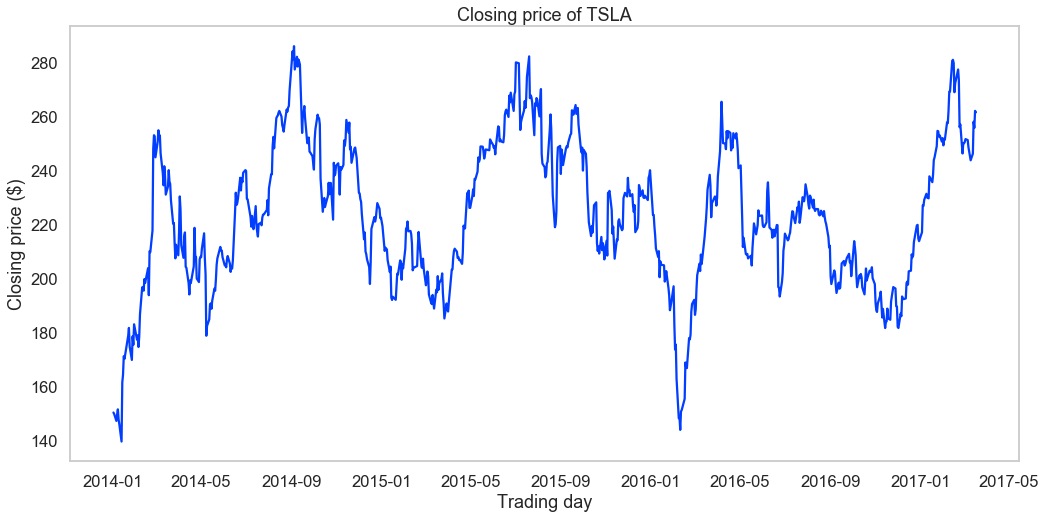

In [10]:
# Visualized the closing price through years

plt.figure(figsize=(17, 8))
plt.plot(df['Close'].iloc[884:])
plt.title('Closing price of TSLA')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [11]:
# Helper function to apply and plot the moving average smoothing for a specific time window

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae + scale*deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

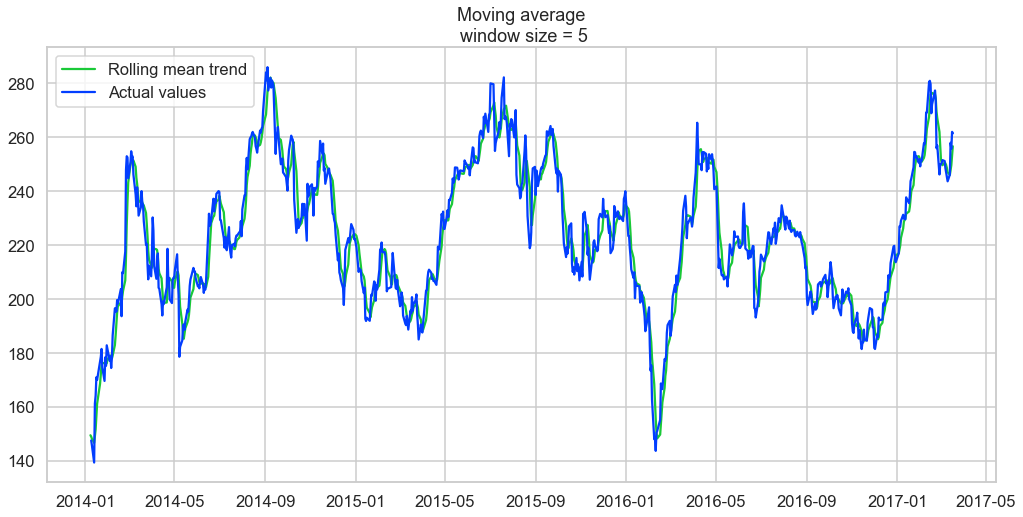

In [12]:
# Smooth by the previous week (5 days)

plot_moving_average(df['Close'].iloc[884:], 5)

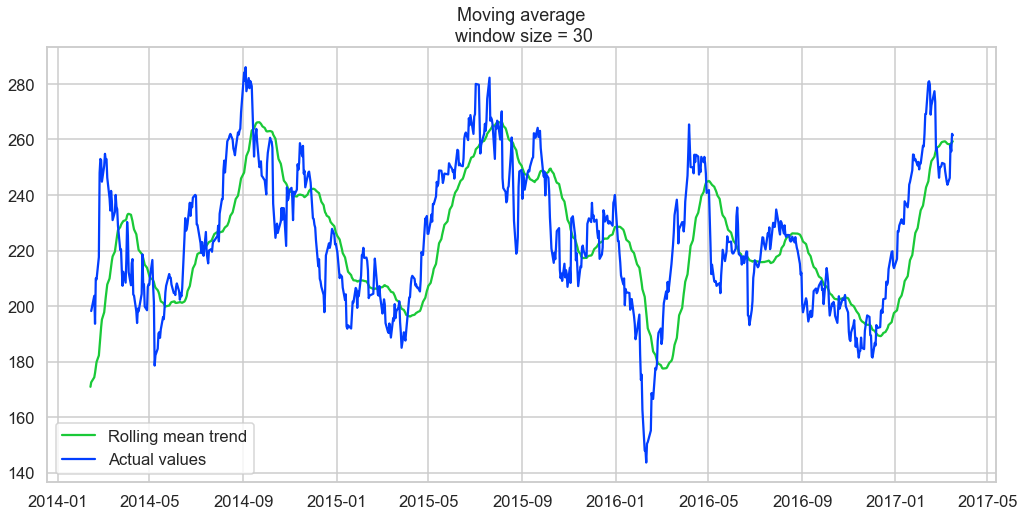

In [13]:
# Smooth by the previous month (30 days)

plot_moving_average(df['Close'].iloc[884:], 30)

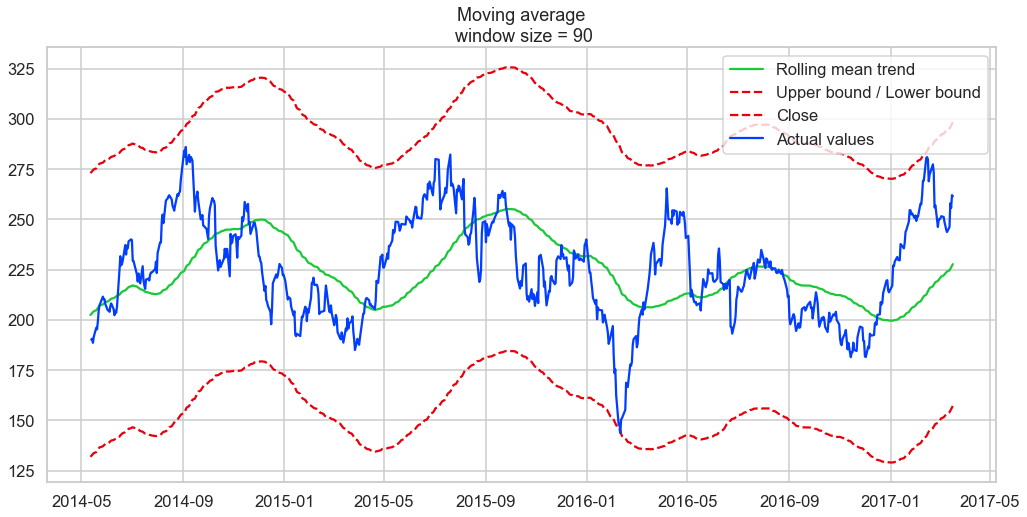

In [14]:
# Smooth by the previous quarter (90 days)

plot_moving_average(df['Close'].iloc[884:], 90, plot_intervals=True)

In [15]:
# Helper function to apply the exponential smoothing for a specific alpha

def exponential_smoothing(series, alpha):
    result = [series[0]] # First value is same as series
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1-alpha)*result[n-1])
    return result

In [16]:
# Helper function to plot the exponential smoothing for specific alphas

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

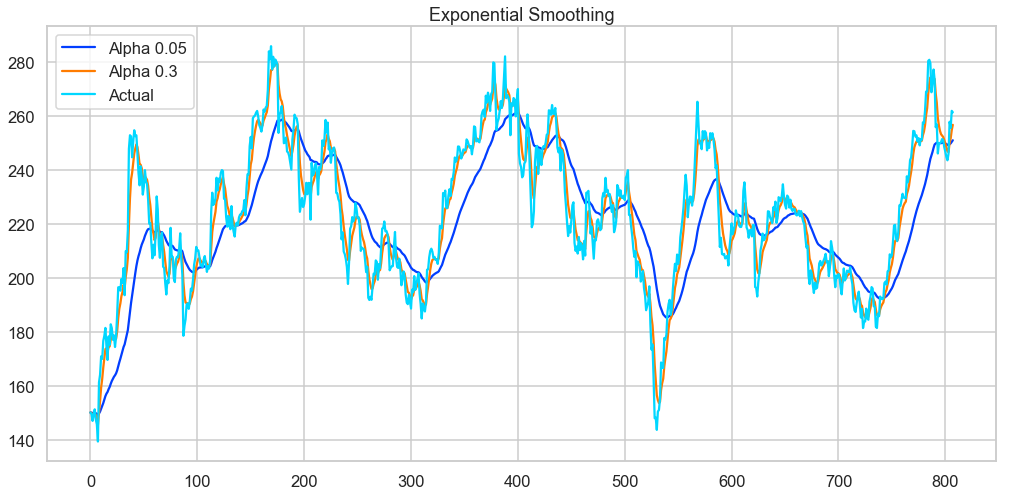

In [17]:
plot_exponential_smoothing(df['Close'].iloc[884:], [0.05, 0.3])

In [18]:
# Helper function to apply the double exponential smoothing for specific alpha and beta

def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # Forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [19]:
# Helper function to plot the double exponential smoothing for specific alphas and betas

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

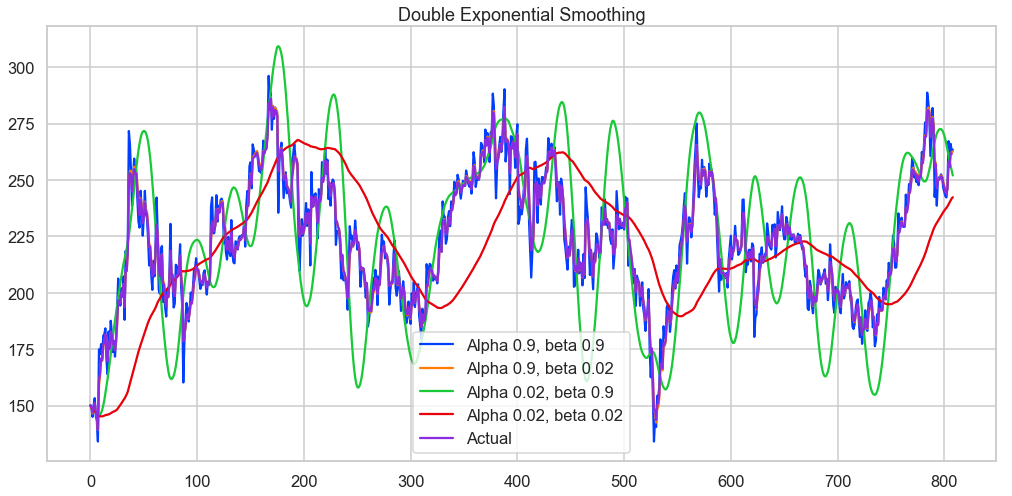

In [20]:
plot_double_exponential_smoothing(df['Close'].iloc[884:], alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [21]:
# Function to plot time series analysis, Dickey-Fuller test, ACF, PACF

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series): # Convert in series if not
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={round(p_value, 5)}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

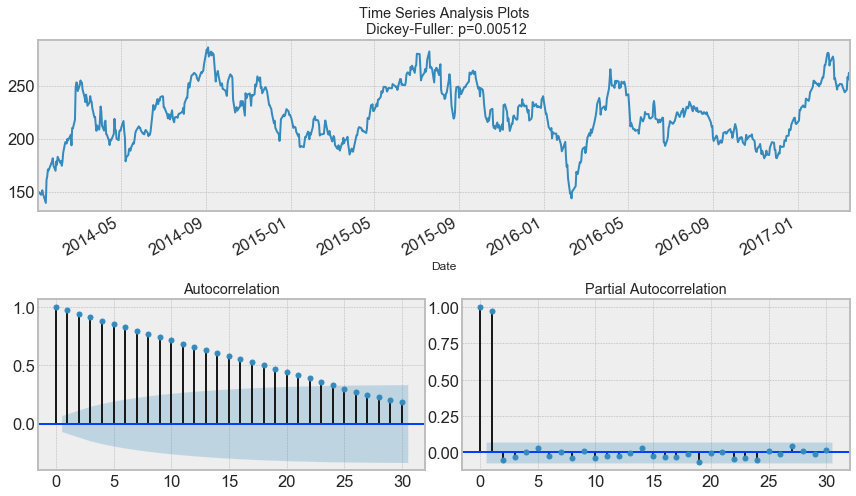

In [22]:
tsplot(df['Close'].iloc[884:], lags=30)

In [23]:
# Take the first difference (1 day) to remove high autocorrelation and make the series stationary

df_diff = df['Close'].iloc[884:] - df['Close'].iloc[884:].shift(1)

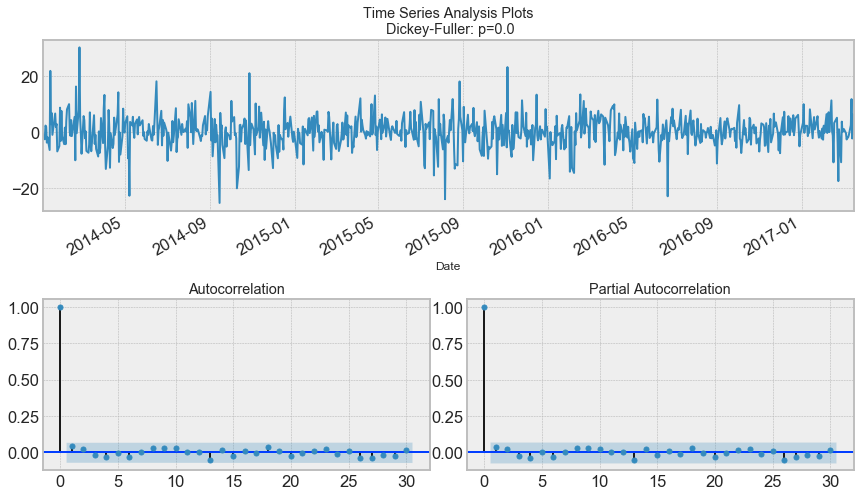

In [24]:
tsplot(df_diff[1:], lags=30)

In [25]:
# Set initial values and some bounds

ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

In [26]:
# Create a list with all possible combinations of parameters

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [27]:
# Function to find the best parameters for SARIMA

def optimize_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df['Close'].iloc[884:], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
    
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    
    return result_table

In [28]:
# result_table = optimize_SARIMA(parameters_list, d, D, s)

In [29]:
# result_table.to_pickle("./result_table.pkl")

In [30]:
result_table = pd.read_pickle("./result_table.pkl")

In [31]:
result_table

,0,1
0,"(0, 0, 0, 0)",5631.375684
1,"(0, 0, 0, 1)",5098.472949
2,"(0, 0, 0, 2)",5100.462869
3,"(0, 0, 0, 3)",5101.655287
4,"(0, 0, 0, 4)",5103.208773
5,"(0, 0, 1, 0)",5383.052080
6,"(0, 0, 1, 1)",5100.463077
7,"(0, 0, 1, 2)",5098.090624
8,"(0, 0, 1, 3)",5099.902438
9,"(0, 0, 1, 4)",5100.289032


In [32]:
result_table.columns = ['Parameters', 'AIC']

In [33]:
result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)

In [34]:
result_table

,Parameters,AIC
0,"(1, 0, 3, 4)",5092.604249
1,"(0, 1, 3, 4)",5092.675581
2,"(0, 1, 4, 4)",5093.560599
3,"(1, 0, 4, 4)",5093.763107
4,"(2, 0, 3, 4)",5094.149606
5,"(0, 2, 3, 4)",5094.241308
6,"(1, 1, 3, 4)",5094.652636
7,"(0, 0, 4, 4)",5094.936818
8,"(0, 2, 4, 4)",5094.986581
9,"(0, 3, 3, 4)",5095.979789


In [35]:
# Set the parameters that give the lowest AIC (Akaike Information Criterion)

p, q, P, Q = result_table['Parameters'][0]

In [36]:
best_model = sm.tsa.statespace.SARIMAX(df['Close'].iloc[884:], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [37]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  808
Model:             SARIMAX(1, 1, 0)x(3, 1, 4, 5)   Log Likelihood               -2537.302
Date:                           Sun, 08 Mar 2020   AIC                           5092.604
Time:                                   16:22:15   BIC                           5134.788
Sample:                                        0   HQIC                          5108.808
                                           - 808                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0473      0.034      1.378      0.168      -0.020       0.115
ar.S.L5       -0.9312      0.041    -22.497      0.000      -1.012      -0.850
ar.S.L10      -0.9010      0.047    -19.090      0.000      -0.994      -0.809
ar.S.L15      -0.9241      0.041    -22.695      0.000      -1.004      -0.844
ma.S.L5       -0.0166      5.262     -0.003      0.997     -10.330      10.296
ma.S.L10      -0.0087      5.205     -0.002      0.999     -10.210      10.193
ma.S.L15       0.0166      5.180      0.003      0.997     -10.137      10.170
ma.S.L20      -0.9912      5.212     -0.190      0.849     -11.207       9.225
sigma2        31.3662    164.375      0.191      0.849    -290.803     353.535
===================================================================================
Ljung-Box (Q):                       21.22   Jarque-Bera (JB):               244.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# Assigned the date column as index and converted it into datetime format

YF_df = pd.read_csv('TSLA.csv', index_col=['Date'], parse_dates=['Date'])

In [39]:
YF_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-17,264.000000,265.329987,261.200012,261.500000,261.500000,6497500
2017-03-20,260.600006,264.549988,258.820007,261.920013,261.920013,3614300
2017-03-21,262.829987,264.799988,250.240005,250.679993,250.679993,6908600
2017-03-22,251.559998,255.070007,250.509995,255.009995,255.009995,4059300
2017-03-23,255.389999,257.670013,253.300003,254.779999,254.779999,3320200
2017-03-24,255.699997,263.890015,255.009995,263.160004,263.160004,5647300
2017-03-27,260.600006,270.570007,259.750000,270.220001,270.220001,6230800
2017-03-28,277.019989,280.679993,275.000000,277.450012,277.450012,7987600
2017-03-29,278.339996,279.600006,275.540009,277.380005,277.380005,3676200


In [40]:
# Predictions from the best model for next month

predictions = best_model.predict(start=809, end=827)

In [41]:
predictions_list = predictions.tolist()

In [42]:
predictions_list

[263.92540353776036,
 264.43532838663407,
 266.3139752699786,
 265.6000606567133,
 266.96002598354653,
 267.91046790588246,
 267.49503949673897,
 268.3172758764785,
 267.9031146736655,
 266.7743984698501,
 266.33348049850014,
 264.8624270677806,
 264.8021166011531,
 266.8615085254642,
 266.2337124369057,
 265.1516301809228,
 264.73134156291593,
 262.4701662172156,
 264.4580265411967]

In [43]:
actuals_list = YF_df['Close'].iloc[1:].tolist()

In [44]:
actuals_list

[261.920013,
 250.67999300000002,
 255.00999500000003,
 254.77999900000003,
 263.160004,
 270.22000099999997,
 277.450012,
 277.380005,
 277.920013,
 278.299988,
 298.519989,
 303.700012,
 295.0,
 298.700012,
 302.540009,
 312.390015,
 308.709991,
 296.839996,
 304.0]

In [45]:
# Created dataframe with the predicted and actual prices

comparison = pd.DataFrame({'predicted': predictions_list,
                           'actual': actuals_list},
                          index = pd.date_range(start='2017-03-20', periods=19))

In [46]:
comparison

,predicted,actual
2017-03-20,263.925404,261.920013
2017-03-21,264.435328,250.679993
2017-03-22,266.313975,255.009995
2017-03-23,265.600061,254.779999
2017-03-24,266.960026,263.160004
2017-03-25,267.910468,270.220001
2017-03-26,267.495039,277.450012
2017-03-27,268.317276,277.380005
2017-03-28,267.903115,277.920013
2017-03-29,266.774398,278.299988


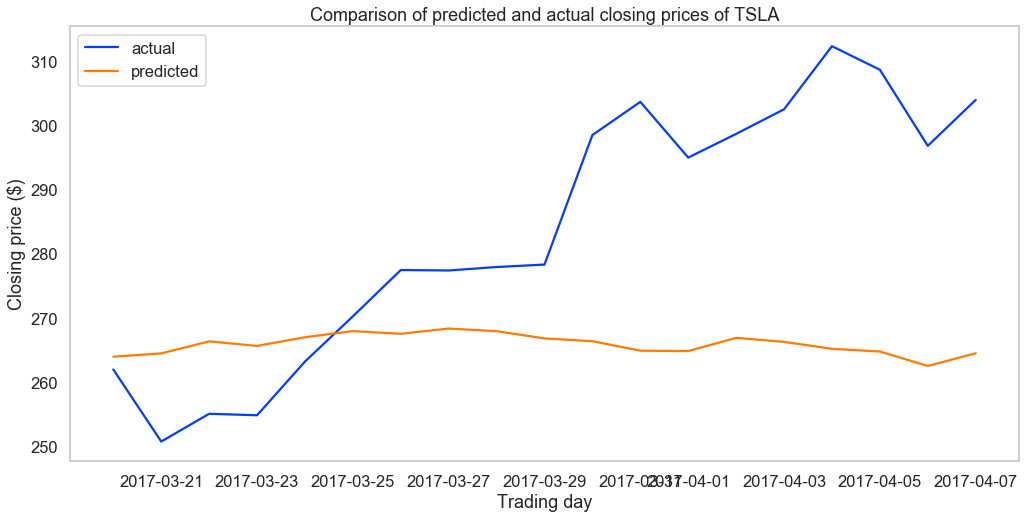

In [47]:
# Visualized the predicted and actual closing prices for next month

plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Comparison of predicted and actual closing prices of TSLA')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()